In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Random
using Distributions
# using FFTW
# using FFTA
# using Pkg
# Pkg.add("AbstractGPs")
# Pkg.add("LogExpFunctions")
using AbstractGPs, LogExpFunctions, Turing


In [2]:

function fft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

function ifft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

ifft (generic function with 1 method)

In [3]:

function fft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft(view(B, y, :))
    end
    return B
end

function ifft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = ifft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = ifft(view(B, y, :))
    end
    return B
end

ifft (generic function with 2 methods)

In [4]:
function custom_fftshift(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
function custom_fftshift(A::AbstractVector)
    n1 = length(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    return A[idx1]
end

function fftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(fft(custom_fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(ifft(custom_fftshift(B)))./(reduce(*,size(B)))
end

ifftnshift (generic function with 1 method)

In [5]:
function meshgrid(x,y)
    n = length(y)
    m = length(x)
    X = Matrix{eltype(x)}(undef, n, m)
    Y = Matrix{eltype(y)}(undef, n, m)
    @views @simd for i in eachindex(y)
        X[i,:] = x
    end
    @views @simd for j in eachindex(x)
        Y[:,j] = y
    end
    return X, Y
end
# function fftnshift(A::AbstractArray)
#     B = copy(A)
#     return fftshift(fft(fftshift(B)))
# end
# function ifftnshift(A::AbstractArray)
#     B = copy(A)
#     return fftshift(ifft(ifftshift(B)))
# end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end

Autocorrelation (generic function with 1 method)

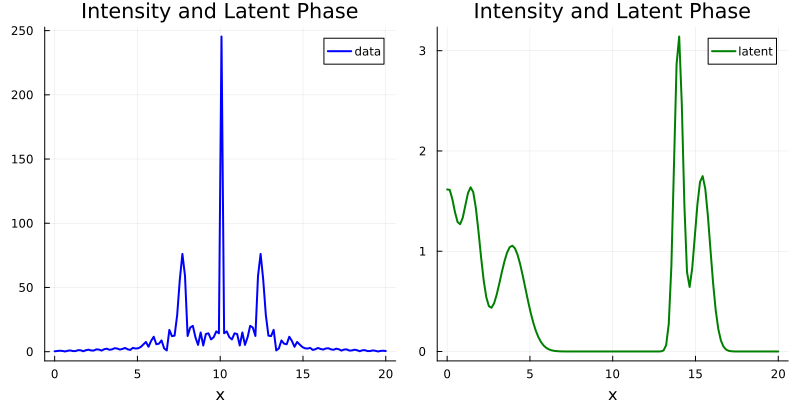

In [21]:
gaussian(x, σ) = @. exp(-x^2 / (2σ^2)) / (σ * sqrt(2π))
Random.seed!(1)
n = 2^7
N_electrons = 10_0000
L = 20
ϵ = 0.01
y_latent = zeros(n)
x_train = collect(range(0.0, L, n))
for i in 1:5
    x0 = rand(Uniform(0, L))
    σ = rand(truncated(Normal(0, 1), 0.1, 1))
    y_latent += gaussian(x_train.-x0, σ) #.+ ϵ * randn(n)
end
# y_latent += ϵ * randn(n)
y_latent = y_latent ./ maximum(y_latent).*pi



Reference_Wave(θ) = @. cis(2*π * (sin(θ)*x_train))
wave_ref = Reference_Wave(0.8)
# Intensity = 2 .+ cos.(y_latent)
Intensity = @. abs2(wave_ref + cis(y_latent))
Intensity_fft = abs.(fftnshift(Intensity))
y_train = @. rand(Poisson(Intensity_fft*N_electrons))

y_reconstruction_test = abs.(ifftnshift(fftnshift(y_latent)))
@assert y_latent ≈ y_reconstruction_test "these are not the same"

fig1 = plot(x_train, y_train./N_electrons, 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)

fig2 = plot(x_train, y_latent, 
    label = "latent", 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, color = :green, linewidth = 2)

plot(fig1, fig2, layout = (1, 2), size = (800, 400), 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "", 
    label = ["data" "latent"], 
    markersize = 2, color = [:blue :green], linewidth = 2)

50


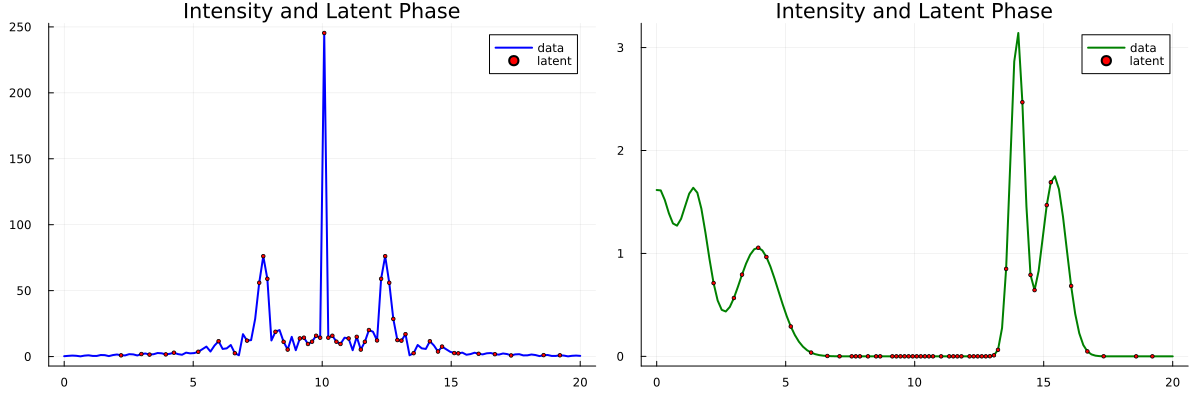

In [25]:
using InducingPoints
M = 35
s = 5
kernel = with_lengthscale(SqExponentialKernel(), 0.2)
noise = 1e-6
alg = Greedy(50, s)
# alg = GreedyVarSelection(100, 1e-6)

Z = inducingpoints(alg, x_train; y=y_train, kernel, noise)
# Z = inducingpoints(alg, y_train; kernel=kernel)
println(length(Z))
Z_indices = [findmin(abs2.(x_train .- z_i))[2] for z_i in Z]

# plot(x_train, y_latent, 
#     label = "latent", 
#     title = "Intensity and Latent Phase", 
#     xlabel = "x", ylabel = "",
#     markersize = 2, size = (800, 400), color = :green, linewidth = 2)
fig1 = plot(x_train, y_train./N_electrons, 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)
# scatter!(x_train[Z_indices], y_latent[Z_indices], 
#     label = "inducing points", 
#     markersize = 5, 
#     color = :red, linewidth = 2)
scatter!(x_train[Z_indices], y_train[Z_indices]./N_electrons, 
    label = "", 
    markersize = 5, 
    color = :red, linewidth = 2)
# plot!(legend = :topright, legendtitle = "Legend")
fig2 = plot(x_train, y_latent, 
    label = "latent", 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "",
    markersize = 2, color = :green, linewidth = 2)
scatter!(fig2, x_train[Z_indices], y_latent[Z_indices], 
    label = "inducing points", 
    markersize = 5, 
    color = :red, linewidth = 2)
plot(fig1, fig2, layout = (1, 2), size = (1200, 400), 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "", 
    label = ["data" "latent"], 
    markersize = 2, color = [:blue :green], linewidth = 2)  

In [8]:

Link(z) = π * logistic(z)

Link (generic function with 1 method)

In [39]:
using ReverseDiff
using Turing
using Distributions
using Statistics: mean, median
using LogExpFunctions
using AbstractGPs

# spacing = 3
@model function latent_model(y, x_input, N_poisson, spacing)
    θ ~ truncated(Normal(0.1, 1), 0, π/2)
    # v ~ InverseGamma(1, 1)
    # v ~ Exponential(2)
    # v ~ Beta(1,20)
    l ~ InverseGamma(1, 1)
    # l ~ truncated(Normal(0.0, 5/n), 0, 1)
    # l ~ Exponential(0.5)
    # l ~ Beta(1,20)
    # v      ~ Gamma(1, 1)           # amplitude prior (mean ≈ 2.5)
    v      ~ truncated(Normal(0, π/2),0,π)           # amplitude prior (mean ≈ 2.5)
    # l      ~ LogNormal(log(0.04), 0.4) # length-scale prior
    # l      ~ Gamma(1,1) # length-scale prior

    # shift ~ Uniform(0.0, π)
    # jitter ~ Uniform(0, 0.04)
    jitter = 1e-6
    
    f = GP(v * with_lengthscale(SEKernel(), l))
    # f_latent ~ truncated(f(x_input, jitter), -0.2, π/2 + 0.2)
    f_latent ~ f(x_input, jitter)
    # f_latent = Link.(f_latent_raw)
    
    local wr = Reference_Wave(θ)
    local I = @. abs($fftnshift(   abs2(wr[1:spacing:end] + cis(f_latent))  ))* N_poisson

    
    # Turing.@addlogprob! -λ * inv(length(basis)-2) * sum((diff(diff(weights))).^2)
    # Turing.@addlogprob! sum(logpdf.(Poisson.(I), y))  # ← scales by N
    # logistic_weight = 100.0
    # Turing.@addlogprob!( logistic_weight * sum(log.(logistic.(f_latent))) )

    y ~ arraydist(Poisson.(I))
end
function model_lambda(λ)
    global init_params
    global global_samples
    global weights_2_plot
    model = latent_model(y_train, x_train, N_electrons, λ)
    sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
    chain = sample(model, sampler, global_samples; progress=true, initial_params=init_params)
    
    # Reconstruct weights_samples as a matrix of size (iterations × n_basis)
    weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:length(basis)])
    mode_weights = mapslices(x -> median(x), weights_samples, dims=1) |> vec
    init_params = mode_weights
    global_samples = 1000
    reconstructed_spline = Spline(basis, mode_weights)
    latent_phi = reconstructed_spline.(x_train)
    return latent_phi, mode_weights, chain
end
λs = collect(range(0.0, 1000, 10))
global global_samples = 5000
# global init_params = ones(length(basis) + 1)
# latent_phis = Matrix{Float64}(undef, length(λs), length(x_train))
# weights_samples = Matrix{Float64}(undef, length(λs), length(basis))
# for (i, λ) in enumerate(λs)
#     latent_phis[i, :], weights_samples[i,:], chain = model_lambda(λ)
# end

5000

In [40]:
# global init_params = fill(0.0, length(x_train) + 1)
# init_params[1] = 0.8
spacing = 2
nchains = 4
model = latent_model(y_train[1:spacing:end], x_train[1:spacing:end], N_electrons, spacing)
sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
# sampler = Turing.NUTS(max_depth=8)

chain = sample(model, sampler, 500; progress=true)
# chain = sample(model, sampler, MCMCThreads(), n, nchains, progress=true)


Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/nicolas/.julia/packages/Turing/IXycm/src/mcmc/hmc.jl:207
Sampling   0%|▏                                         |  ETA: 0:13:56
Sampling   1%|▍                                         |  ETA: 0:06:59
Sampling   1%|▌                                         |  ETA: 0:04:40
Sampling   2%|▋                                         |  ETA: 0:03:31
Sampling   2%|▉                                         |  ETA: 0:02:49
Sampling   2%|█                                         |  ETA: 0:02:24
Sampling   3%|█▏                                        |  ETA: 0:02:03
Sampling   3%|█▍                                        |  ETA: 0:01:48
Sampling   4%|█▌                                        |  ETA: 0:01:36
Sampling   4%|█▋                                        |  ETA: 0:01:27
Sampling   4%|█▉                                        |  ETA: 0:01:19
Sampli

Chains MCMC chain (500×47×1 Array{Float64, 3}):

Iterations        = 251:1:750
Number of chains  = 1
Samples per chain = 500
Wall duration     = 87.9 seconds
Compute duration  = 87.9 seconds
parameters        = θ, l, v, f_latent[1], f_latent[2], f_latent[3], f_latent[4], f_latent[5], f_latent[6], f_latent[7], f_latent[8], f_latent[9], f_latent[10], f_latent[11], f_latent[12], f_latent[13], f_latent[14], f_latent[15], f_latent[16], f_latent[17], f_latent[18], f_latent[19], f_latent[20], f_latent[21], f_latent[22], f_latent[23], f_latent[24], f_latent[25], f_latent[26], f_latent[27], f_latent[28], f_latent[29], f_latent[30], f_latent[31], f_latent[32]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ⋯
        Symbol   Float64   Float64   

In [11]:
# mle_estimate = maximum_likelihood(model)
map_estimate = maximum_a_posteriori(model)

ModeResult with maximized lp of -224.58
[0.2751977046193779, 0.07147855221321675, 2.9155437726414335, 3.5940458311599626, 1.3396143667147986, 0.17477686063507242, 0.7448951550183416, 1.663111055462315, 1.5771958766881686, 0.733108879980051  …  -0.11933228216797781, 0.13242886037022197, -0.1590449225815198, -0.29089939357389644, 0.5602259715937886, 1.8644714187098574, 2.2790660634673428, 1.3369143456465749, -0.2857005044963888, -1.7606028337365311]

In [12]:
size(mle_estimate.values)
plot(Link.(map_estimate.values[5:end]), marker=:circle, lw=2,
     title="ModeResult (maximized lp = -220.50)",
     xlabel="Index", ylabel="Value", label="ModeResult")

UndefVarError: UndefVarError: `mle_estimate` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

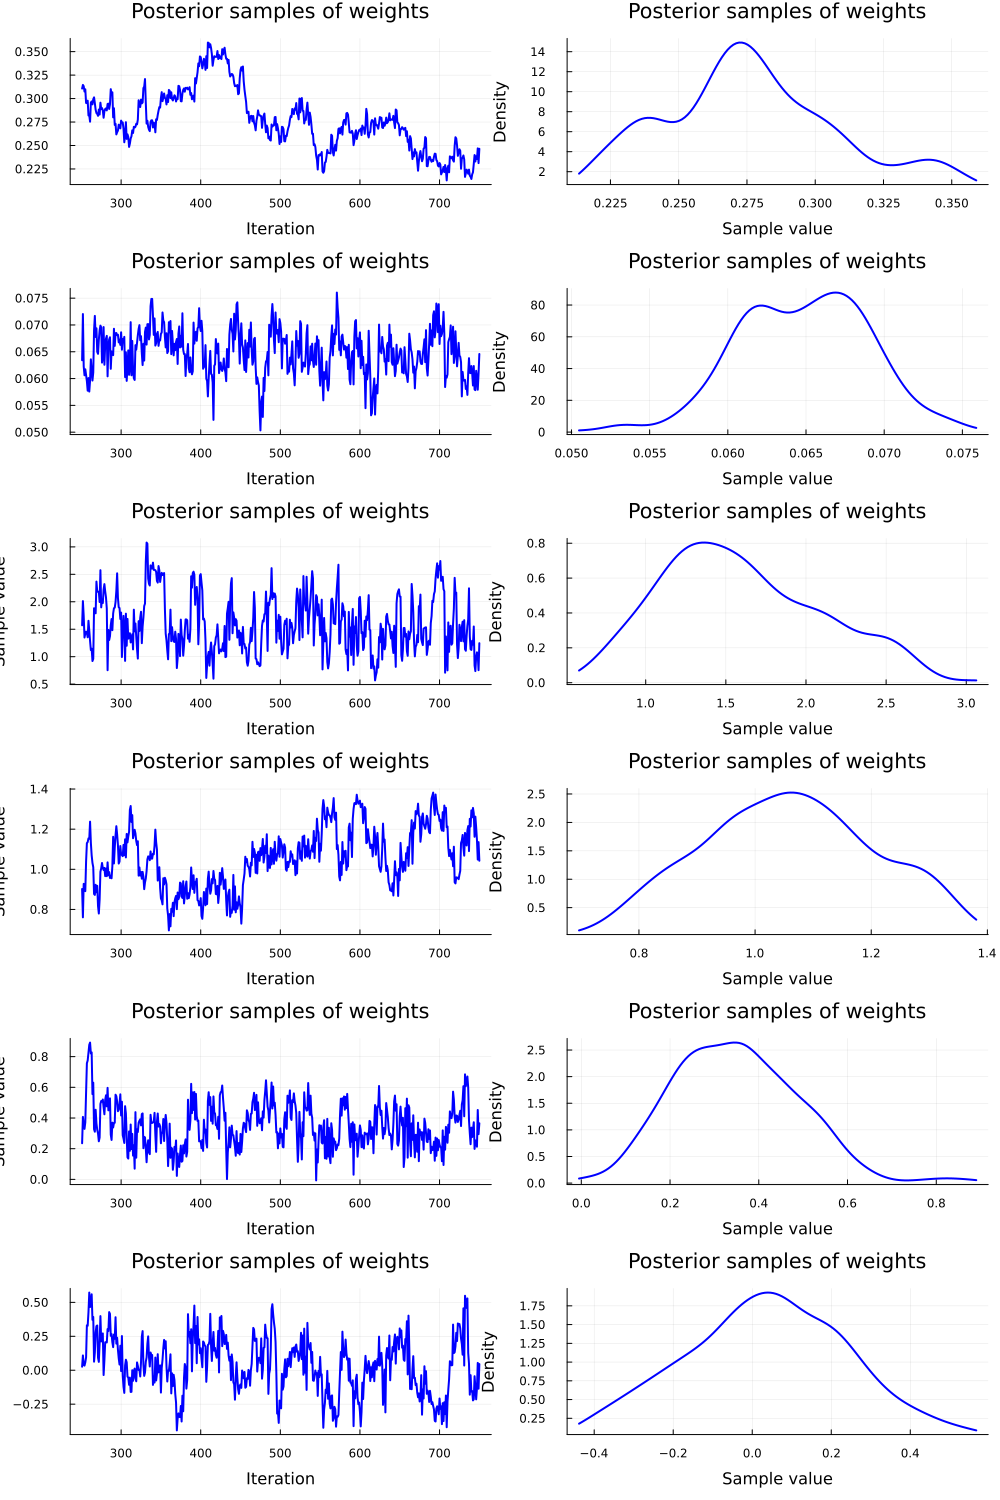

In [42]:
using StatsPlots
plot(chain[:,1:6,1], 
    title = "Posterior samples of weights", 
    xlabel = "Iterations", ylabel = "Weights", 
    label = ["w[$i]" for i in 1:10], 
    markersize = 2, color = :blue, linewidth = 2)

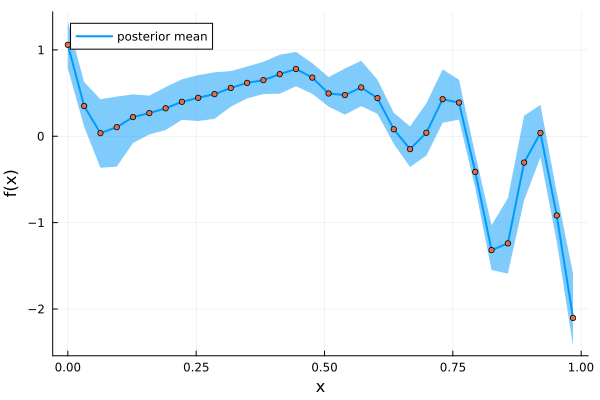

In [43]:
using MCMCChains, Statistics, StatsPlots   # <- add this
N     = length(x_train[1:spacing:end])                       # number of latent points
nsamp = length(chain[:,1,1])  # total posterior draws

# allocate once for speed
f_samples = Matrix{Float64}(undef, nsamp, N)  
I_reconstructed = Matrix{Float64}(undef, nsamp, N)  # reconstructed intensity
for i in 1:N
    # each column i holds the posterior draws of f_latent[i]
    f_samples[:, i] = Array(chain["f_latent[$i]"])   # note the string key
end
# f_samples = π .* logistic.(f_samples)  # transform to latent phase
using Statistics

f_mean  = mean(f_samples, dims = 1) |> vec               # N-vector
f_low   = mapslices(p -> quantile(p, 0.025), f_samples; dims = 1) |> vec
f_high  = mapslices(p -> quantile(p, 0.975), f_samples; dims = 1) |> vec
using StatsPlots                      # brings `plot` and `ribbon`

plot(x_train[1:spacing:end], (f_mean);
     ribbon = (f_mean .- f_low, f_high .- f_mean),   # symmetric ribbon
     label  = "posterior mean",
     xlabel = "x", ylabel = "f(x)",
     legend = :topleft, lw = 2)

scatter!(x_train[1:spacing:end], f_mean; ms = 3, label = "")        # optional markers


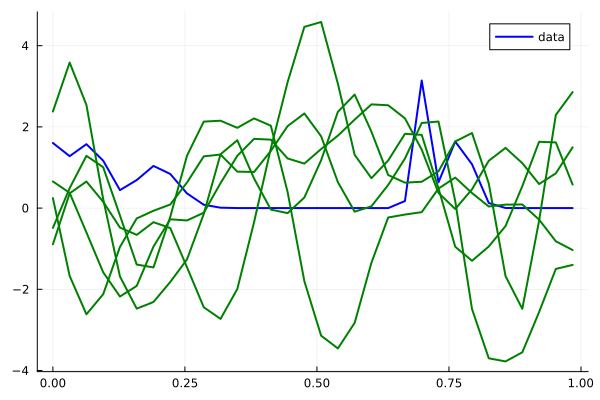

In [38]:
v_samples = Array(chain[:v])
l_samples = Array(chain[:l])
# jitter_samples = Array(chain[:jitter])
fig1 = plot(x_train[1:spacing:end], y_latent[1:spacing:end], 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)
for i in 100:100:500
    # Construct GP with sampled hyperparameters
    kernel = v_samples[i] * with_lengthscale(SEKernel(), l_samples[i])
    f = GP(kernel)
    f_latent = rand(f(x_train[1:spacing:end], 1e-6))
    plot!(x_train[1:spacing:end], f_latent, 
        label = "", 
        markersize = 2, color = :green, linewidth = 2)
end
display(fig1)


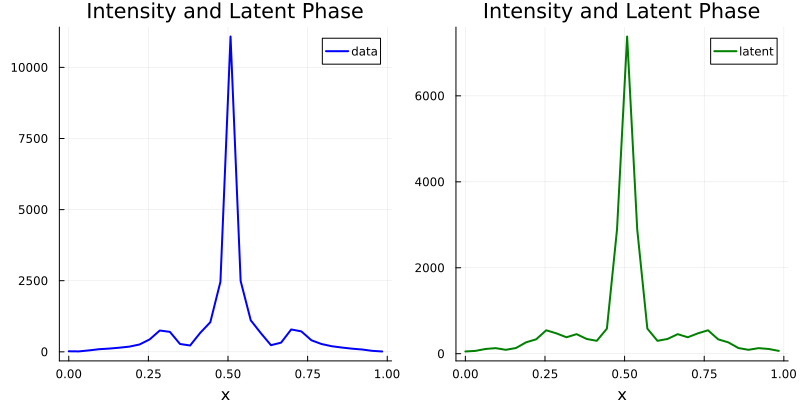

In [51]:
using MCMCChains, Statistics, StatsPlots   # <- add this
N     = length(x_train[1:spacing:end])                       # number of latent points
nsamp = length(chain[:,1,1])  # total posterior draws

# allocate once for speed
f_samples = Matrix{Float64}(undef, nsamp, N)  
θ_samples = Matrix{Float64}(undef, nsamp, 1)
I_reconstructed = Matrix{Float64}(undef, nsamp, N)  # reconstructed intensity
for i in 1:N
    # each column i holds the posterior draws of f_latent[i]
    # θ_samples[:, i] = Array(chain["θ"])   # note the string key
    f_samples[:, i] = Array(chain["f_latent[$i]"])   # note the string key
end
# f_samples = π .* logistic.(f_samples)  # transform to latent phase
using Statistics

f_mean  = mean(f_samples, dims = 1) |> vec               # N-vector
f_low   = mapslices(p -> quantile(p, 0.025), f_samples; dims = 1) |> vec
f_high  = mapslices(p -> quantile(p, 0.975), f_samples; dims = 1) |> vec
using StatsPlots                      # brings `plot` and `ribbon`
I_reconstructed = @. abs($fftnshift(   abs2(wave_ref[1:spacing:end] + cis(f_mean))  ))* N_electrons

# plot(x_train[1:spacing:end], (f_mean);
#      ribbon = (f_mean .- f_low, f_high .- f_mean),   # symmetric ribbon
#      label  = "posterior mean",
#      xlabel = "x", ylabel = "f(x)",
#      legend = :topleft, lw = 2)

# scatter!(x_train[1:spacing:end], f_mean; ms = 3, label = "")

fig1 = plot(x_train[1:spacing:end], y_train[1:spacing:end], 
    label = "data", 
    markersize = 2, 
    color = :blue, linewidth = 2)
fig2 = plot(x_train[1:spacing:end], I_reconstructed,

    label = "reconstructed intensity", 
    markersize = 2, color = :green, linewidth = 2)

plot(fig1, fig2, layout = (1, 2), size = (800, 400), 
    title = "Intensity and Latent Phase", 
    xlabel = "x", ylabel = "", 
    label = ["data" "latent"], 
    markersize = 2, color = [:blue :green], linewidth = 2)

In [16]:
# Function to reconstruct GP from MCMC samples
function reconstruct_gp_posterior(chain, x_train, x_test=nothing)
    # If no test points are provided, use training points
    if isnothing(x_test)
        x_test = x_train
    end
    
    # Extract hyperparameters
    v_samples = chain[:v].value.data
    l_samples = chain[:l].value.data
    jitter_samples = chain[:jitter].value.data
    f_latent_samples = reduce(hcat, [chain[Symbol("f_latent[$i]")] for i in 1:length(x_train)])
    
    # Number of posterior samples
    n_samples = length(v_samples)
    
    # Initialize array to store predictions
    posterior_means = zeros(n_samples, length(x_test))
    posterior_vars = zeros(n_samples, length(x_test))
    f_samples = zeros(n_samples, length(x_test))
    
    # For each posterior sample
    for i in 1:n_samples
        # Construct GP with sampled hyperparameters
        kernel = v_samples[i] * with_lengthscale(SEKernel(), l_samples[i])
        f = GP(kernel)
        
        # Condition on the sampled latent values
        f_posterior = posterior(f(x_train, jitter_samples[i]), f_latent_samples[i, :])
        
        # Predict at test points
        μ, σ² = mean_and_var(f_posterior(x_test))
        posterior_means[i, :] = μ
        posterior_vars[i, :] = σ²
        
        # Also sample a function from the posterior for visualization
        f_samples[i, :] = rand(f_posterior(x_test))
    end
    
    return posterior_means, posterior_vars, f_samples
end

# Example usage:
# posterior_means, posterior_vars, f_samples = reconstruct_gp_posterior(chain, x_train)

# Visualize results
function plot_gp_posterior(x_test, posterior_means, posterior_vars, f_samples, y_latent=nothing)
    # Calculate statistics across samples
    mean_prediction = vec(mean(posterior_means, dims=1))
    lower_quantile = vec(mapslices(col -> quantile(col, 0.025), posterior_means, dims=1))
    upper_quantile = vec(mapslices(col -> quantile(col, 0.975), posterior_means, dims=1))
    
    # Create plot
    p = plot(xlabel="x", ylabel="f(x)", title="GP Posterior")
    
    # Plot individual samples
    for i in 1:min(100, size(f_samples, 1))
        plot!(p, x_test, f_samples[i, :], alpha=0.1, color=:blue, label="")
    end
    
    # Plot mean prediction and credible intervals
    plot!(p, x_test, mean_prediction, lw=2, color=:red, label="Mean")
    plot!(p, x_test, lower_quantile, lw=1, color=:black, ls=:dash, label="95% CI")
    plot!(p, x_test, upper_quantile, lw=1, color=:black, ls=:dash, label="")
    
    # Add true function if provided
    if !isnothing(y_latent)
        plot!(p, x_test, y_latent, lw=2, color=:green, label="True")
    end
    
    return p
end

# Example usage:
# Function to reconstruct and interpolate GP from MCMC samples
function reconstruct_gp_posterior_full(chain, x_train_sub, x_test)
    # Extract hyperparameters - use Array() to get values directly
    v_samples = Array(chain[:v])[:, 1]  # Getting values from first chain
    l_samples = Array(chain[:l])[:, 1]
    jitter_samples = Array(chain[:jitter])[:, 1]
    
    # Extract f_latent values (only for subsampled points)
    f_latent_samples = hcat([Array(chain[Symbol("f_latent[$i]")])[:, 1] for i in 1:length(x_train_sub)]...)
    
    # Number of posterior samples
    n_samples = length(v_samples)
    
    # Initialize arrays for predictions on the full grid
    posterior_means = zeros(n_samples, length(x_test))
    posterior_vars = zeros(n_samples, length(x_test))
    f_samples_full = zeros(n_samples, length(x_test))
    
    # For each posterior sample
    for i in 1:n_samples
        # Construct GP with sampled hyperparameters
        kernel = v_samples[i] * with_lengthscale(SEKernel(), l_samples[i])
        f = GP(kernel)
        
        # Condition on the sampled latent values
        f_posterior = posterior(f(x_train_sub, jitter_samples[i]), f_latent_samples[i, :])
        
        # Predict at all test points
        μ, σ² = mean_and_var(f_posterior(x_test))
        posterior_means[i, :] = μ
        posterior_vars[i, :] = σ²
        
        # Sample a function from the posterior
        f_samples_full[i, :] = rand(f_posterior(x_test))
    end
    
    return posterior_means, posterior_vars, f_samples_full
end
function reconstruct_gp_posterior_full_no_samples(chain, x_train_sub, x_test)
    # Same extraction code as before
    v_samples = Array(chain[:v])[:, 1]
    l_samples = Array(chain[:l])[:, 1]
    jitter_samples = Array(chain[:jitter])[:, 1]
    f_latent_samples = hcat([Array(chain[Symbol("f_latent[$i]")])[:, 1] for i in 1:length(x_train_sub)]...)
    
    n_samples = length(v_samples)
    posterior_means = zeros(n_samples, length(x_test))
    posterior_vars = zeros(n_samples, length(x_test))
    
    for i in 1:n_samples
        kernel = v_samples[i] * with_lengthscale(SEKernel(), l_samples[i])
        f = GP(kernel)
        # Add extra stability jitter
        extra_jitter = 1e-6
        f_posterior = posterior(f(x_train_sub, jitter_samples[i] + extra_jitter), f_latent_samples[i, :])
        μ, σ² = mean_and_var(f_posterior(x_test))
        posterior_means[i, :] = μ
        posterior_vars[i, :] = σ²
    end
    
    # Don't return samples, modify the plot function to work without them
    return posterior_means, posterior_vars
end
# Usage example:
x_subsampled = x_train[1:spacing:end]
posterior_means_full, posterior_vars_full, f_samples_full = 
    reconstruct_gp_posterior_full_no_samples(chain, x_subsampled, x_train)

# Plot the reconstructed GP on the full grid
p2 = plot_gp_posterior(x_train, posterior_means_full, posterior_vars_full, f_samples_full, y_latent)

ArgumentError: ArgumentError: index jitter not found

In [17]:
weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:length(basis)])
mode_weights = mapslices(x -> median(x), weights_samples, dims=1) |> vec
init_params = mode_weights
# global_samples = 1000
# Extract weights for iteration 100
fig1 = plot(x_train, y_latent, 
        # label = "λ = $(λs[1])", 
        markersize = 2, color = :red, linewidth = 2)
for k in 100:100:2000
    weight_values = [chain[k, Symbol("weights[$i]"), 1] for i in 1:length(basis)]
    reconstructed_spline = Spline(basis, weight_values)
    phi_reconstructed = reconstructed_spline.(x_train)

    plot!(x_train, phi_reconstructed, 
        title = "Posterior samples of weights", 
        xlabel = "", ylabel = "", 
        markersize = 2, color = :blue, linewidth = 2, alpha =0.1)
    
end
plot!(legend=false)
display(fig1)

UndefVarError: UndefVarError: `basis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
θ_reconstructed = median(chain[:,1,1])
println("θ_reconstructed = ", θ_reconstructed)
wr_reconstructed = Reference_Wave(θ_reconstructed)
I = @. abs($fftnshift(   abs2(wr_reconstructed + cis(phi_reconstructed))  ))* N_electrons
plot(x_train, I, 
    title = "Posterior samples of weights", 
    xlabel = "x", ylabel = "", 
    markersize = 2, color = :blue, linewidth = 2)
plot!(x_train, y_train,
    title = "Posterior samples of weights", 
    xlabel = "x", ylabel = "", 
    color = :red, linewidth = 2, linestyle =:dash)

xlims!(5, 15)

θ_reconstructed = 0.8853407691909444


UndefVarError: UndefVarError: `phi_reconstructed` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [19]:
color_gradient = cgrad(:viridis, length(λs), categorical=true)
fig1 = plot()
for (i,lambda_val) in enumerate(λs)
    plot!(x_train[1:spacing:end], weights_samples[i, 1:end-1],
        title = "Latent Phase", 
        xlabel = "λ", 
        ylabel = "latent phase",
        label = "λ = $(round(lambda_val, digits=2))",
        markersize = 2, 
        size = (800, 400),
        color = color_gradient[i],
        linewidth = 2)
end
display(fig1)

UndefVarError: UndefVarError: `weights_samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
println(size(latent_phis))
println(length(x_train))

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
lp = copy(latent_phis);

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [22]:
# fig1 = plot() 
color_gradient = cgrad(:viridis, length(λs), categorical=true)

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, latent_phis[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, color = :blue, linewidth = 2)
# end
fig1 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# latent_phis = abs.(latent_phis)
for (i, lambda_val) in enumerate(λs[1:end])
      i == 8 ? continue :
      plot!(x_train, latent_phis[i, :],
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2, alpha=0.5)
end
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
# plot!(legend = false)
# plot!(x_train, phis_recovered[1, :],
#           label = "",
#           markersize = 2, 
#           color =:black,  # Use color from gradient
#           linewidth = 3, linestyle = :dash)
display(fig1)



UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(latent_phis[1, :])
phi_d_scale = maximum(phi_diff) 
phi_λ_diff = Matrix{Float64}(undef, length(λs), length(x_train)-1)


for (i, lambda_val) in enumerate(λs)
      phi_diff = diff(latent_phis[i, :])
      phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
      phi_λ_diff[i, :] = phi_diff
      plot!(x_train[1:end-1], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig2)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [24]:
fig3 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
phi_diff = diff(diff(latent_phis[1, :]))
phi_d_scale = maximum(phi_diff) 
phi_λ_diff2 = Matrix{Float64}(undef, length(λs), length(x_train)-2)


for (i, lambda_val) in enumerate(λs)
    phi_diff = diff(diff(latent_phis[i, :]))
    phi_diff = phi_diff ./ maximum(phi_diff) 
    phi_λ_diff2[i, :] = phi_diff
    plot!(x_train[1:end-2], phi_diff,
          label = "λ = $(round(lambda_val, digits=2))",
          markersize = 2, 
          color = color_gradient[i],  # Use color from gradient
          linewidth = 2)
end
plot!(x_train[1:end-2], diff(diff(y_latent))./maximum(diff(diff(y_latent))),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig3)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [25]:
size(phi_λ_diff)

UndefVarError: UndefVarError: `phi_λ_diff` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [26]:
fig1 = heatmap(x_train, λs, latent_phis, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(x_train[1:end-1], λs, phi_λ_diff, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(x_train[1:end-2], λs, phi_λ_diff2, 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
conv(x, c=0.5) = log.(1 .+ c.*abs.(fftnshift(x)))
fig1 = heatmap(conv(latent_phis,0.1), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig2 = heatmap(conv(phi_λ_diff), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
fig3 = heatmap(conv(phi_λ_diff2), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)
plot(fig1, fig2, fig3, layout = (3, 1), 
     size = (800, 1000), 
     title = "Latent Phase Heatmap", 
     xlabel = "x", ylabel = "λ", 
     colorbar_title = "Intensity")

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
idx = length(λs) ÷ 2 +1
plot(abs.(fft_phis[idx,:]))

UndefVarError: UndefVarError: `fft_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [29]:

N_window = 0
fft_phis = fftnshift(latent_phis)
filtered_fft = copy(fft_phis)
filtered_fft .= 0
filtered_fft[idx-N_window:idx+N_window,:] = fft_phis[idx-N_window:idx+N_window,:]
# fft_phis[end÷2-N_window:end÷2+N_window,:] .= 0
phis_recovered = ifftnshift(filtered_fft)
fig1 = heatmap(x_train, λs, abs.(phis_recovered), 
        title = "Latent Phase Heatmap", 
        xlabel = "x", ylabel = "λ", 
        size=(800, 500), 
        color = :viridis, 
        c=:viridis)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [30]:
original_energy = sum(abs2.(filtered_fft))

idx =0 #+  length(λs) ÷ 2 
# phis_recovered = abs.(ifftnshift(filtered_fft[10:end,:]))
filtered_energy = sum(abs2.(filtered_fft[1:end-idx,:]))
scale_factor = sqrt(original_energy / filtered_energy)
phis_recovered = abs.(ifftnshift(filtered_fft[1:end-idx,:].* scale_factor)) 
fig1 = plot()

# for (i, lambda_val) in enumerate(λs)
#     plot!(x_train, phis_recovered[i, :],
#           label = "λ = $(round(lambda_val, digits=2))",
#           markersize = 2, 
#           color = color_gradient[i],  # Use color from gradient
#           linewidth = 2)
# end
plot!(x_train, phis_recovered[1, :],
          label = "",
          markersize = 2, 
          color =:black, linestyle=:dash,  # Use color from gradient
          linewidth = 2)
plot!(x_train, y_latent,
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
plot!(legend = false)
display(fig1)


UndefVarError: UndefVarError: `filtered_fft` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [31]:
heatmap(phi_λ_diff)

UndefVarError: UndefVarError: `phi_λ_diff` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [32]:
fig2 = plot(title="Spline Results for Different λ Values", 
            xlabel="x", ylabel="Phase", 
            size=(800, 500))
# phi_diff = diff(latent_phis[1, :])
# phi_d_scale = maximum(phi_diff) 


phi_diff = diff(latent_phis, dims=1)
# phi_diff = phi_diff ./ maximum(phi_diff) * phi_d_scale
plot!(λs[1:end-1], phi_diff,
        markersize = 2, 
        color = color_gradient,  # Use color from gradient
        linewidth = 2)

plot!(x_train[1:end-1], diff(y_latent),
      label = "latent",
      markersize = 2, 
      color = :red, linewidth = 2)
display(fig2)

UndefVarError: UndefVarError: `latent_phis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

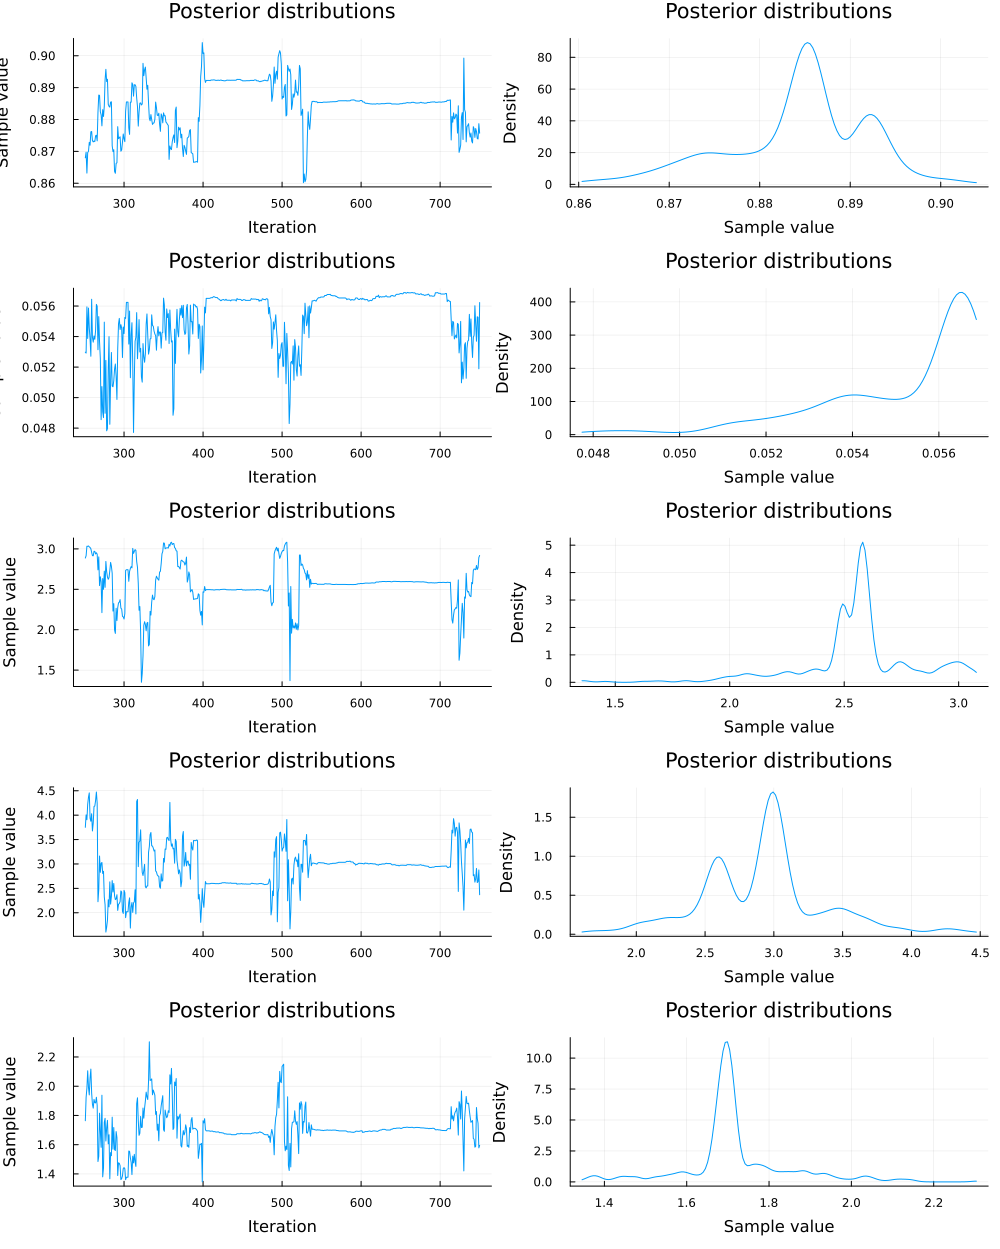

In [33]:
using StatsPlots
plot(chain[:,1:5,:], 
    vars = [:v, :l, :jitter], 
    title = "Posterior distributions", 
    label = ["v" "l" "jitter"], 
    legend = false)

In [34]:
using Statistics, Plots, Unwrap

n_weights = length(basis)
# n_iter, n_weights = size(weights_samples)

n_basis = length(basis)  # Should be 41

# Reconstruct weights_samples as a matrix of size (iterations × n_basis)
weights_samples = reduce(hcat, [chain[Symbol("weights[$i]")] for i in 1:n_basis])
using StatsBase
mode_weights = mapslices(x -> median(x), weights_samples, dims=1) |> vec

# Then build the spline
reconstructed_spline = Spline(basis, mode_weights)
I_recon = (2 .+ cos.(reconstructed_spline.(x_train))) 

# I_latent = unwrap(acos.(I_recon .- 2))
# I_latent = (I_recon .- 2)

p = plot(x_train, zeros(length(x_train)),
    xlabel="x", ylabel="",
    title="Multiple BSpline Reconstructions", label="", lw=1, color=:gray)

# Plot a subset of the reconstructions to avoid clutter.
for i in 100:1:length(chain[:,1,1])
    w = weights_samples[i, :]          # current weights sample
    spline_i = Spline(basis, w)          # build spline
    I_recon_i = (spline_i.(x_train)) # evaluate at x_train
    # I_recon_i = unwrap(acos.(clamp.(I_recon_i,-1,1)))
    plot!(p, x_train, I_recon_i, lw=1, label="", alpha=0.01, color=:red)
end
ylims!(-.1, 3.2)
plot!(x_train,reconstructed_spline.(x_train),
    label = "Inferred Phase", 
    markersize = 2, 
    color = :black, linewidth = 2, linestyle = :dash)
plot!(x_train, y_train./N_electrons, 
    label = "", 
    markersize = 2, 
    color = :blue, linewidth = 2)
# plot!(x_train, (y_latent),
#     label = "True Intensity", 
#     markersize = 2, 
#     color = :green, linewidth = 2)
plot!(x_train, y_latent,
    label = "", 
    markersize = 2, 
    color = :green, linewidth = 2)

UndefVarError: UndefVarError: `basis` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
plot(fig5, fig4, fig1, fig2, fig3, layout = (1,5), size = (1200, 400), 
    title = "First Derivative", 
    xlabel = "x", ylabel = "dφ/dx", 
    label = "", legend = false)

UndefVarError: UndefVarError: `fig5` not defined in `Main`
Suggestion: check for spelling errors or missing imports.